<a href="https://colab.research.google.com/github/fmejias/CienciasDeLosDatosTEC/blob/master/AprendizajeAutomatico/TP2/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ciencias de los Datos:
# Aprendizaje automático

## Trabajo práctico 2

- Professor: M.Sc.Saul Calderon.

- Students: 
    - Felipe Alberto Mejías Loría, Instituto Tecnológico de Costa Rica. 
    - María Auxiliadora Mora, Instituto Tecnológico de Costa Rica  

- July 28th, 2019   

In [0]:
# Libraries required for the exercises
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np;
import pandas as pandas;
from scipy import ndimage
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split as tts

## 1. Implementación de clasificadores lineales de dos clases. (40 puntos)

Sample data linearly separable


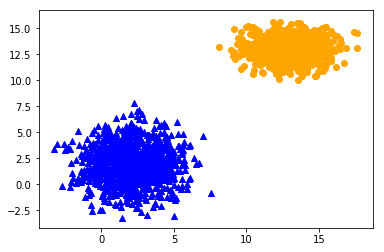

>epoch=0, cost=9960.982
>epoch=1, cost=9145.868
>epoch=2, cost=9049.159
>epoch=3, cost=9007.712
>epoch=4, cost=8924.819
>epoch=5, cost=8828.110
>epoch=6, cost=8316.938
>epoch=7, cost=3840.712
>epoch=8, cost=9739.935
>epoch=9, cost=8924.819
>epoch=10, cost=8897.188
>epoch=11, cost=8772.849
>epoch=12, cost=8537.985
>epoch=13, cost=7874.840
>epoch=14, cost=6216.979
>epoch=15, cost=248.678
>epoch=16, cost=41.445
>epoch=17, cost=27.630
>epoch=18, cost=27.630
>epoch=19, cost=27.630
>epoch=20, cost=13.814
>epoch=21, cost=13.814
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp


>epoch=57, cost=-0.001
>epoch=58, cost=-0.001
>epoch=59, cost=-0.001
>epoch=60, cost=-0.001
>epoch=61, cost=-0.001
>epoch=62, cost=-0.001
>epoch=63, cost=-0.001
>epoch=64, cost=-0.001
>epoch=65, cost=-0.001
>epoch=66, cost=-0.001
>epoch=67, cost=-0.001
>epoch=68, cost=-0.001
>epoch=69, cost=-0.001
>epoch=70, cost=-0.001
>epoch=71, cost=-0.001
>epoch=72, cost=-0.001
>epoch=73, cost=-0.001
>epoch=74, cost=-0.001
>epoch=75, cost=-0.001
>epoch=76, cost=-0.001
>epoch=77, cost=-0.001
>epoch=78, cost=-0.001
>epoch=79, cost=-0.001
>epoch=80, cost=-0.001
>epoch=81, cost=-0.001
>epoch=82, cost=-0.001
>epoch=83, cost=-0.001
>epoch=84, cost=-0.001
>epoch=85, cost=-0.001
>epoch=86, cost=-0.001
>epoch=87, cost=-0.001
>epoch=88, cost=-0.001
>epoch=89, cost=-0.001
>epoch=90, cost=-0.001
>epoch=91, cost=-0.001
>epoch=92, cost=-0.001
>epoch=93, cost=-0.001
>epoch=94, cost=-0.001
>epoch=95, cost=-0.001
>epoch=96, cost=-0.001
>epoch=97, cost=-0.001
>epoch=98, cost=-0.001
>epoch=99, cost=-0.001
Error total

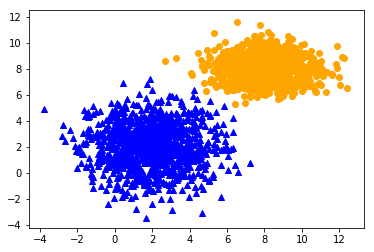

>epoch=0, cost=9947.167
>epoch=1, cost=9214.944
>epoch=2, cost=9118.236
>epoch=3, cost=9035.344
>epoch=4, cost=8579.432
>epoch=5, cost=9739.934
>epoch=6, cost=9049.159
>epoch=7, cost=8911.003
>epoch=8, cost=8620.878
>epoch=9, cost=7239.327
>epoch=10, cost=9739.934
>epoch=11, cost=8883.372
>epoch=12, cost=8676.140
>epoch=13, cost=8040.626
>epoch=14, cost=6092.639
>epoch=15, cost=4780.167
>epoch=16, cost=7861.024
>epoch=17, cost=5512.388
>epoch=18, cost=1478.259
>epoch=19, cost=3232.829
>epoch=20, cost=5153.185
>epoch=21, cost=7833.394
>epoch=22, cost=5567.650
>epoch=23, cost=41.445
>epoch=24, cost=41.445
>epoch=25, cost=27.630
>epoch=26, cost=27.630
>epoch=27, cost=27.630
>epoch=28, cost=27.630
>epoch=29, cost=27.630
>epoch=30, cost=27.630
>epoch=31, cost=27.630
>epoch=32, cost=27.630
>epoch=33, cost=13.814
>epoch=34, cost=27.630
>epoch=35, cost=27.630
>epoch=36, cost=27.630
>epoch=37, cost=13.814
>epoch=38, cost=27.630
>epoch=39, cost=27.630
>epoch=40, cost=27.630
>epoch=41, cost=13.81

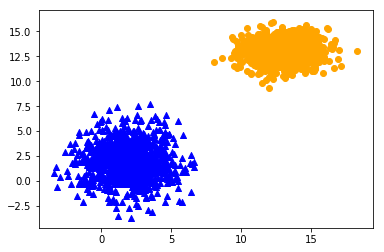

>epoch=0, cost=10002.429
>epoch=1, cost=9118.236
>epoch=2, cost=9076.790
>epoch=3, cost=9049.159
>epoch=4, cost=8993.896
>epoch=5, cost=8869.557
>epoch=6, cost=8482.723
>epoch=7, cost=5484.757
>epoch=8, cost=9712.304
>epoch=9, cost=8938.635
>epoch=10, cost=8911.004
>epoch=11, cost=8759.032
>epoch=12, cost=8620.878
>epoch=13, cost=8123.519
>epoch=14, cost=6728.153
>epoch=15, cost=1298.657
>epoch=16, cost=41.445
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, 

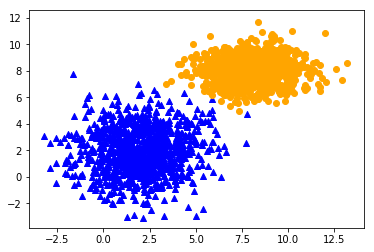

>epoch=0, cost=9891.906
>epoch=1, cost=9214.944
>epoch=2, cost=9145.866
>epoch=3, cost=9076.789
>epoch=4, cost=8620.878
>epoch=5, cost=9574.149
>epoch=6, cost=9076.789
>epoch=7, cost=8966.266
>epoch=8, cost=8634.693
>epoch=9, cost=7184.064
>epoch=10, cost=9574.149
>epoch=11, cost=8883.373
>epoch=12, cost=8648.509
>epoch=13, cost=8095.888
>epoch=14, cost=5733.437
>epoch=15, cost=9201.129
>epoch=16, cost=8662.324
>epoch=17, cost=8413.645
>epoch=18, cost=7474.190
>epoch=19, cost=3882.158
>epoch=20, cost=41.445
>epoch=21, cost=41.445
>epoch=22, cost=41.445
>epoch=23, cost=41.445
>epoch=24, cost=41.445
>epoch=25, cost=41.445
>epoch=26, cost=41.445
>epoch=27, cost=27.630
>epoch=28, cost=27.630
>epoch=29, cost=27.630
>epoch=30, cost=27.630
>epoch=31, cost=27.630
>epoch=32, cost=27.630
>epoch=33, cost=27.630
>epoch=34, cost=27.630
>epoch=35, cost=27.630
>epoch=36, cost=27.630
>epoch=37, cost=27.630
>epoch=38, cost=27.630
>epoch=39, cost=27.630
>epoch=40, cost=27.630
>epoch=41, cost=27.630
>epo

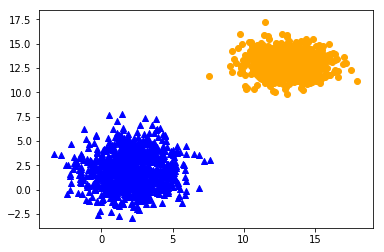

>epoch=0, cost=9739.935
>epoch=1, cost=9339.284
>epoch=2, cost=9325.469
>epoch=3, cost=9256.392
>epoch=4, cost=9187.313
>epoch=5, cost=8924.819
>epoch=6, cost=8303.121
>epoch=7, cost=953.269
>epoch=8, cost=151.969
>epoch=9, cost=13.814
>epoch=10, cost=-0.001
>epoch=11, cost=-0.001
>epoch=12, cost=-0.001
>epoch=13, cost=-0.001
>epoch=14, cost=-0.001
>epoch=15, cost=-0.001
>epoch=16, cost=-0.001
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=-0.001
>epoc

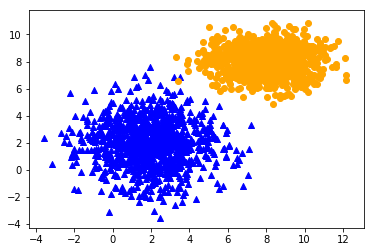

>epoch=0, cost=10057.691
>epoch=1, cost=9007.713
>epoch=2, cost=9007.713
>epoch=3, cost=8952.450
>epoch=4, cost=8620.878
>epoch=5, cost=55.261
>epoch=6, cost=41.445
>epoch=7, cost=13.814
>epoch=8, cost=13.814
>epoch=9, cost=27.630
>epoch=10, cost=27.630
>epoch=11, cost=27.630
>epoch=12, cost=27.630
>epoch=13, cost=27.630
>epoch=14, cost=27.630
>epoch=15, cost=27.630
>epoch=16, cost=27.630
>epoch=17, cost=27.630
>epoch=18, cost=27.630
>epoch=19, cost=27.630
>epoch=20, cost=27.630
>epoch=21, cost=13.814
>epoch=22, cost=41.445
>epoch=23, cost=13.814
>epoch=24, cost=41.445
>epoch=25, cost=13.814
>epoch=26, cost=41.445
>epoch=27, cost=13.814
>epoch=28, cost=41.445
>epoch=29, cost=13.814
>epoch=30, cost=27.630
>epoch=31, cost=27.630
>epoch=32, cost=27.630
>epoch=33, cost=27.630
>epoch=34, cost=27.630
>epoch=35, cost=27.630
>epoch=36, cost=27.630
>epoch=37, cost=27.630
>epoch=38, cost=27.630
>epoch=39, cost=27.630
>epoch=40, cost=27.630
>epoch=41, cost=27.630
>epoch=42, cost=27.630
>epoch=43,

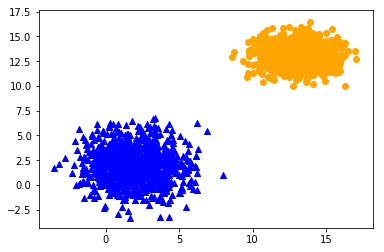

>epoch=0, cost=9850.459
>epoch=1, cost=9256.391
>epoch=2, cost=9242.576
>epoch=3, cost=9214.945
>epoch=4, cost=9145.867
>epoch=5, cost=9021.528
>epoch=6, cost=8427.460
>epoch=7, cost=898.007
>epoch=8, cost=-0.001
>epoch=9, cost=-0.001
>epoch=10, cost=-0.001
>epoch=11, cost=-0.001
>epoch=12, cost=-0.001
>epoch=13, cost=-0.001
>epoch=14, cost=-0.001
>epoch=15, cost=-0.001
>epoch=16, cost=-0.001
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=-0.001
>epoch

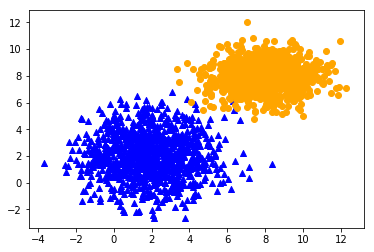

>epoch=0, cost=9850.458
>epoch=1, cost=9173.498
>epoch=2, cost=9159.683
>epoch=3, cost=9062.975
>epoch=4, cost=8510.354
>epoch=5, cost=9615.595
>epoch=6, cost=9090.605
>epoch=7, cost=9007.713
>epoch=8, cost=8551.801
>epoch=9, cost=6507.104
>epoch=10, cost=9615.595
>epoch=11, cost=8952.451
>epoch=12, cost=8662.324
>epoch=13, cost=7930.103
>epoch=14, cost=4434.778
>epoch=15, cost=9615.595
>epoch=16, cost=8745.218
>epoch=17, cost=8358.384
>epoch=18, cost=7695.238
>epoch=19, cost=4476.225
>epoch=20, cost=2804.548
>epoch=21, cost=5843.960
>epoch=22, cost=41.445
>epoch=23, cost=41.445
>epoch=24, cost=41.445
>epoch=25, cost=41.445
>epoch=26, cost=41.445
>epoch=27, cost=55.261
>epoch=28, cost=69.076
>epoch=29, cost=41.445
>epoch=30, cost=69.076
>epoch=31, cost=55.261
>epoch=32, cost=69.076
>epoch=33, cost=41.445
>epoch=34, cost=69.076
>epoch=35, cost=55.261
>epoch=36, cost=55.261
>epoch=37, cost=69.076
>epoch=38, cost=41.445
>epoch=39, cost=69.076
>epoch=40, cost=55.261
>epoch=41, cost=69.076


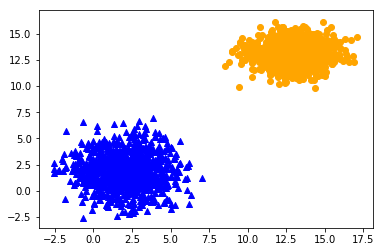

>epoch=0, cost=9629.410
>epoch=1, cost=9518.887
>epoch=2, cost=9491.256
>epoch=3, cost=9435.993
>epoch=4, cost=9339.285
>epoch=5, cost=9118.236
>epoch=6, cost=8510.354
>epoch=7, cost=2141.403
>epoch=8, cost=9587.963
>epoch=9, cost=9325.470
>epoch=10, cost=9214.944
>epoch=11, cost=9118.236
>epoch=12, cost=8855.741
>epoch=13, cost=8275.490
>epoch=14, cost=6341.318
>epoch=15, cost=566.435
>epoch=16, cost=13.814
>epoch=17, cost=13.814
>epoch=18, cost=13.814
>epoch=19, cost=13.814
>epoch=20, cost=13.814
>epoch=21, cost=13.814
>epoch=22, cost=13.814
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, co

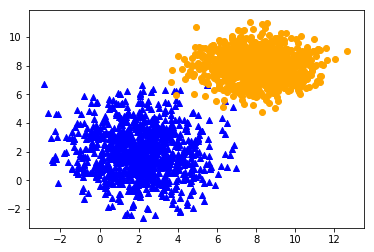

>epoch=0, cost=9753.749
>epoch=1, cost=9408.362
>epoch=2, cost=9325.470
>epoch=3, cost=9159.684
>epoch=4, cost=8662.324
>epoch=5, cost=9684.672
>epoch=6, cost=9159.684
>epoch=7, cost=9021.527
>epoch=8, cost=8717.587
>epoch=9, cost=7087.356
>epoch=10, cost=9684.672
>epoch=11, cost=9021.527
>epoch=12, cost=8786.664
>epoch=13, cost=8275.490
>epoch=14, cost=5415.679
>epoch=15, cost=9684.672
>epoch=16, cost=8869.557
>epoch=17, cost=8551.800
>epoch=18, cost=7847.209
>epoch=19, cost=4945.953
>epoch=20, cost=41.445
>epoch=21, cost=55.261
>epoch=22, cost=55.261
>epoch=23, cost=41.445
>epoch=24, cost=41.445
>epoch=25, cost=41.445
>epoch=26, cost=41.445
>epoch=27, cost=41.445
>epoch=28, cost=41.445
>epoch=29, cost=41.445
>epoch=30, cost=55.261
>epoch=31, cost=55.261
>epoch=32, cost=41.445
>epoch=33, cost=41.445
>epoch=34, cost=41.445
>epoch=35, cost=41.445
>epoch=36, cost=41.445
>epoch=37, cost=55.261
>epoch=38, cost=55.261
>epoch=39, cost=55.261
>epoch=40, cost=41.445
>epoch=41, cost=41.445
>epo

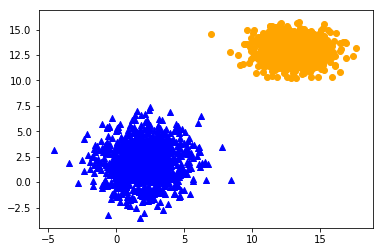

>epoch=0, cost=9795.196
>epoch=1, cost=9270.207
>epoch=2, cost=9242.576
>epoch=3, cost=9214.945
>epoch=4, cost=9159.683
>epoch=5, cost=8952.450
>epoch=6, cost=8275.490
>epoch=7, cost=-0.001
>epoch=8, cost=-0.001
>epoch=9, cost=-0.001
>epoch=10, cost=-0.001
>epoch=11, cost=-0.001
>epoch=12, cost=-0.001
>epoch=13, cost=-0.001
>epoch=14, cost=-0.001
>epoch=15, cost=-0.001
>epoch=16, cost=-0.001
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=-0.001
>epoch=

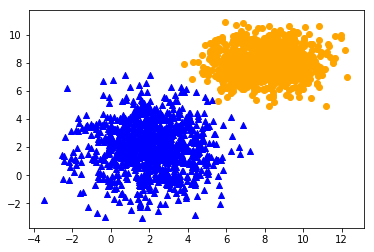

>epoch=0, cost=9960.982
>epoch=1, cost=9076.789
>epoch=2, cost=9035.344
>epoch=3, cost=8938.635
>epoch=4, cost=8676.140
>epoch=5, cost=9726.119
>epoch=6, cost=8938.635
>epoch=7, cost=8883.372
>epoch=8, cost=8703.771
>epoch=9, cost=6728.153
>epoch=10, cost=9726.119
>epoch=11, cost=8869.557
>epoch=12, cost=8731.401
>epoch=13, cost=8261.675
>epoch=14, cost=4130.837
>epoch=15, cost=9726.119
>epoch=16, cost=8772.849
>epoch=17, cost=8468.907
>epoch=18, cost=7957.733
>epoch=19, cost=4434.778
>epoch=20, cost=7460.375
>epoch=21, cost=8427.461
>epoch=22, cost=7833.394
>epoch=23, cost=4642.011
>epoch=24, cost=41.445
>epoch=25, cost=13.814
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.

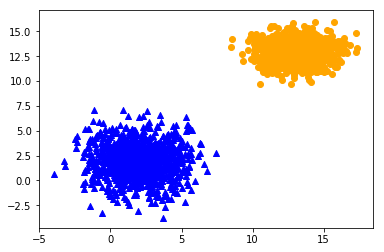

>epoch=0, cost=9698.487
>epoch=1, cost=9394.547
>epoch=2, cost=9366.916
>epoch=3, cost=9325.470
>epoch=4, cost=9214.945
>epoch=5, cost=9021.527
>epoch=6, cost=8275.490
>epoch=7, cost=13.814
>epoch=8, cost=-0.001
>epoch=9, cost=-0.001
>epoch=10, cost=-0.001
>epoch=11, cost=-0.001
>epoch=12, cost=-0.001
>epoch=13, cost=-0.001
>epoch=14, cost=-0.001
>epoch=15, cost=-0.001
>epoch=16, cost=-0.001
>epoch=17, cost=-0.001
>epoch=18, cost=-0.001
>epoch=19, cost=-0.001
>epoch=20, cost=-0.001
>epoch=21, cost=-0.001
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=-0.001
>epoch=

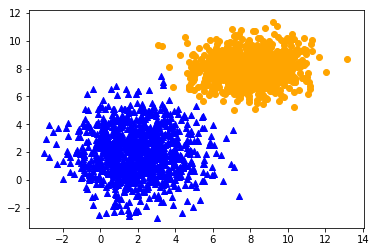

>epoch=0, cost=9753.750
>epoch=1, cost=9297.838
>epoch=2, cost=9270.207
>epoch=3, cost=9104.421
>epoch=4, cost=8579.431
>epoch=5, cost=9574.148
>epoch=6, cost=9159.683
>epoch=7, cost=9049.159
>epoch=8, cost=8593.246
>epoch=9, cost=6824.860
>epoch=10, cost=9574.148
>epoch=11, cost=9007.712
>epoch=12, cost=8703.771
>epoch=13, cost=8151.150
>epoch=14, cost=5139.369
>epoch=15, cost=9560.333
>epoch=16, cost=8828.109
>epoch=17, cost=8482.722
>epoch=18, cost=7778.130
>epoch=19, cost=4766.351
>epoch=20, cost=221.047
>epoch=21, cost=27.630
>epoch=22, cost=27.630
>epoch=23, cost=13.814
>epoch=24, cost=13.814
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>ep

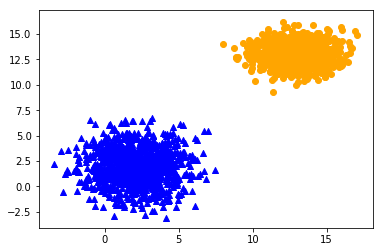

>epoch=0, cost=9878.090
>epoch=1, cost=9201.130
>epoch=2, cost=9187.314
>epoch=3, cost=9145.867
>epoch=4, cost=9049.158
>epoch=5, cost=8911.003
>epoch=6, cost=8358.383
>epoch=7, cost=1298.657
>epoch=8, cost=9601.779
>epoch=9, cost=9062.974
>epoch=10, cost=9035.343
>epoch=11, cost=8897.188
>epoch=12, cost=8800.479
>epoch=13, cost=8192.597
>epoch=14, cost=6258.426
>epoch=15, cost=193.416
>epoch=16, cost=96.707
>epoch=17, cost=41.445
>epoch=18, cost=13.814
>epoch=19, cost=13.814
>epoch=20, cost=13.814
>epoch=21, cost=13.814
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, co

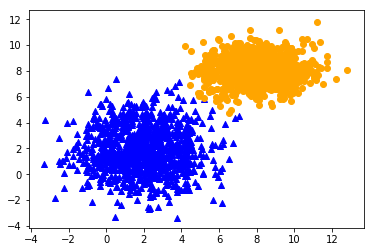

>epoch=0, cost=9836.645
>epoch=1, cost=9104.421
>epoch=2, cost=9104.421
>epoch=3, cost=8993.896
>epoch=4, cost=8565.615
>epoch=5, cost=9090.605
>epoch=6, cost=8980.080
>epoch=7, cost=8814.295
>epoch=8, cost=8496.537
>epoch=9, cost=6631.444
>epoch=10, cost=9657.042
>epoch=11, cost=8800.479
>epoch=12, cost=8620.878
>epoch=13, cost=8012.995
>epoch=14, cost=5705.805
>epoch=15, cost=5747.251
>epoch=16, cost=8082.072
>epoch=17, cost=6769.599
>epoch=18, cost=870.376
>epoch=19, cost=69.076
>epoch=20, cost=41.445
>epoch=21, cost=69.076
>epoch=22, cost=41.445
>epoch=23, cost=69.076
>epoch=24, cost=41.445
>epoch=25, cost=82.892
>epoch=26, cost=41.445
>epoch=27, cost=69.076
>epoch=28, cost=55.261
>epoch=29, cost=55.261
>epoch=30, cost=55.261
>epoch=31, cost=55.261
>epoch=32, cost=69.076
>epoch=33, cost=41.445
>epoch=34, cost=69.076
>epoch=35, cost=41.445
>epoch=36, cost=69.076
>epoch=37, cost=41.445
>epoch=38, cost=69.076
>epoch=39, cost=41.445
>epoch=40, cost=69.076
>epoch=41, cost=41.445
>epoch=

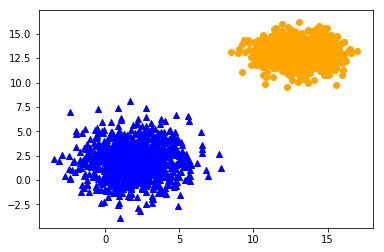

>epoch=0, cost=9919.536
>epoch=1, cost=9062.975
>epoch=2, cost=9035.344
>epoch=3, cost=8993.896
>epoch=4, cost=8924.819
>epoch=5, cost=8772.848
>epoch=6, cost=8164.966
>epoch=7, cost=3108.489
>epoch=8, cost=9657.041
>epoch=9, cost=8897.188
>epoch=10, cost=8828.110
>epoch=11, cost=8676.140
>epoch=12, cost=8399.829
>epoch=13, cost=7930.102
>epoch=14, cost=6092.639
>epoch=15, cost=124.338
>epoch=16, cost=41.445
>epoch=17, cost=41.445
>epoch=18, cost=27.630
>epoch=19, cost=27.630
>epoch=20, cost=27.630
>epoch=21, cost=13.814
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, co

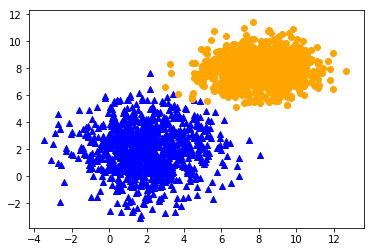

>epoch=0, cost=9739.934
>epoch=1, cost=9339.284
>epoch=2, cost=9311.653
>epoch=3, cost=9187.314
>epoch=4, cost=8620.878
>epoch=5, cost=9587.963
>epoch=6, cost=9214.945
>epoch=7, cost=9007.712
>epoch=8, cost=8634.693
>epoch=9, cost=6562.366
>epoch=10, cost=9587.963
>epoch=11, cost=8993.896
>epoch=12, cost=8745.218
>epoch=13, cost=7999.180
>epoch=14, cost=4448.594
>epoch=15, cost=9587.963
>epoch=16, cost=8828.111
>epoch=17, cost=8441.276
>epoch=18, cost=7709.054
>epoch=19, cost=4503.855
>epoch=20, cost=524.988
>epoch=21, cost=151.969
>epoch=22, cost=82.892
>epoch=23, cost=55.261
>epoch=24, cost=55.261
>epoch=25, cost=55.261
>epoch=26, cost=55.261
>epoch=27, cost=41.445
>epoch=28, cost=55.261
>epoch=29, cost=41.445
>epoch=30, cost=69.076
>epoch=31, cost=41.445
>epoch=32, cost=41.445
>epoch=33, cost=69.076
>epoch=34, cost=41.445
>epoch=35, cost=41.445
>epoch=36, cost=69.076
>epoch=37, cost=41.445
>epoch=38, cost=41.445
>epoch=39, cost=69.076
>epoch=40, cost=41.445
>epoch=41, cost=41.445
>e

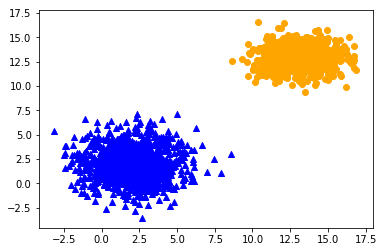

>epoch=0, cost=9878.090
>epoch=1, cost=9242.576
>epoch=2, cost=9201.129
>epoch=3, cost=9145.867
>epoch=4, cost=9104.421
>epoch=5, cost=8938.634
>epoch=6, cost=8330.753
>epoch=7, cost=1782.200
>epoch=8, cost=9698.488
>epoch=9, cost=9090.604
>epoch=10, cost=8966.266
>epoch=11, cost=8869.557
>epoch=12, cost=8717.586
>epoch=13, cost=8220.229
>epoch=14, cost=6659.075
>epoch=15, cost=276.309
>epoch=16, cost=69.076
>epoch=17, cost=55.261
>epoch=18, cost=41.445
>epoch=19, cost=41.445
>epoch=20, cost=13.814
>epoch=21, cost=13.814
>epoch=22, cost=-0.001
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, co

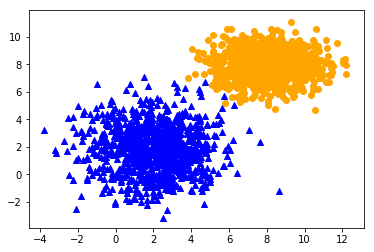

>epoch=0, cost=9905.720
>epoch=1, cost=9104.421
>epoch=2, cost=9035.343
>epoch=3, cost=8980.081
>epoch=4, cost=8689.955
>epoch=5, cost=276.309
>epoch=6, cost=2832.179
>epoch=7, cost=8579.432
>epoch=8, cost=165.785
>epoch=9, cost=55.261
>epoch=10, cost=41.445
>epoch=11, cost=27.630
>epoch=12, cost=27.630
>epoch=13, cost=27.630
>epoch=14, cost=27.630
>epoch=15, cost=27.630
>epoch=16, cost=27.630
>epoch=17, cost=27.630
>epoch=18, cost=41.445
>epoch=19, cost=55.261
>epoch=20, cost=41.445
>epoch=21, cost=13.814
>epoch=22, cost=13.814
>epoch=23, cost=-0.001
>epoch=24, cost=-0.001
>epoch=25, cost=-0.001
>epoch=26, cost=-0.001
>epoch=27, cost=-0.001
>epoch=28, cost=-0.001
>epoch=29, cost=-0.001
>epoch=30, cost=-0.001
>epoch=31, cost=-0.001
>epoch=32, cost=-0.001
>epoch=33, cost=-0.001
>epoch=34, cost=-0.001
>epoch=35, cost=-0.001
>epoch=36, cost=-0.001
>epoch=37, cost=-0.001
>epoch=38, cost=-0.001
>epoch=39, cost=-0.001
>epoch=40, cost=-0.001
>epoch=41, cost=-0.001
>epoch=42, cost=-0.001
>epoc

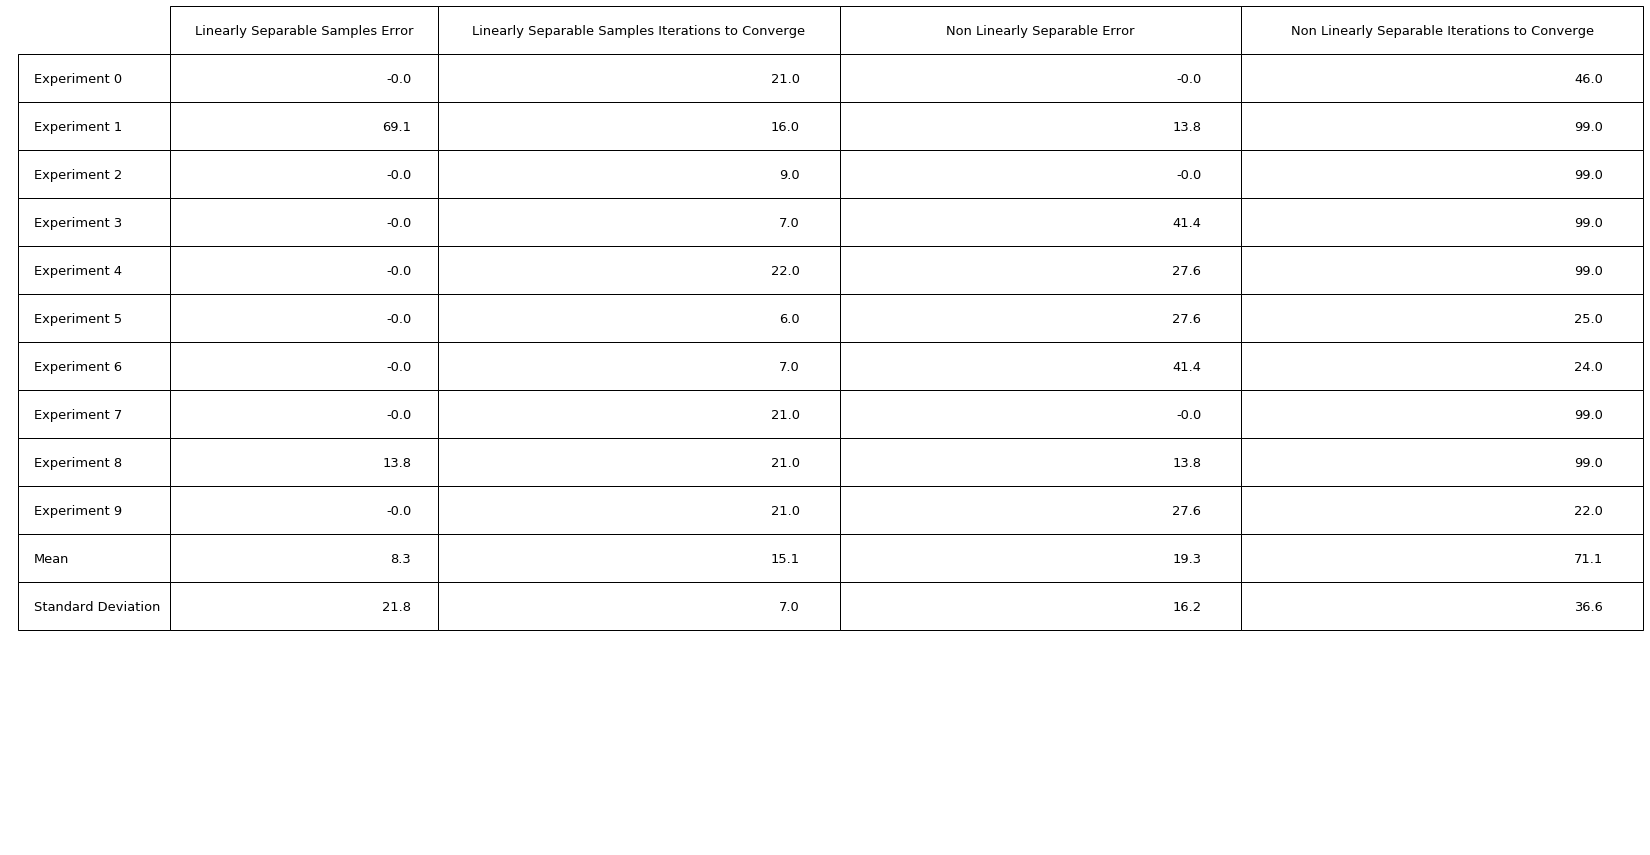

In [157]:
def createData(numberSamplesPerClass = 2, mean1 = [2, 2], mean2 = [6, 6], stds1 = [3, 3], stds2 = [2, 1]):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2
    """
    means = torch.zeros(2)

    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]

    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]
        
    samplesClass1 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)

    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]
    samplesClass2 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    
    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    
    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1], marker='^', c='blue')
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker='o', c='orange')

    plt.show()
    
    # Create samples with bias
    samplesAllBias = torch.cat((samplesClass1Bias, samplesClass2Bias), 0)
    
    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1)
    targetsClass2 = 0 * torch.ones(numberSamplesPerClass, 1)
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)
    
    return (targetsAll, samplesAllBias)


def createDataOneClass(means, covarianceMatrix, numberSamples):
    """
    Creates data with gaussian distribution
    """
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
    return samples

def sigmoid(x):
    """
    Sigmoid activation function
    """
    return 1/(1+np.exp(-x))

def forward(samples, w, threshold=0.5, lowerLimit = 0, upperLimit = 1):
    """
    Get model output.
    param samples: samples used to estimated targets. 
    param w: network's weights. 
    param threshold: neuron's threshold of the transfer function.
    param lowerLimit: lower limit of the transfer function.
    param upperLimit: upper limit of the transfer function.
    return: Estimates the model outputs using the sigmoid activation function with values of lowerLimit and upperLimit.   
    """

    # Define vectorize sigmoid to apply to m*w
    vectorize_sigmoid = np.vectorize(sigmoid)
    EstimatedTargets = samples.mm(w)
    
    # Apply sigmoid function to m*w
    EstimatedTargets = torch.from_numpy(vectorize_sigmoid(EstimatedTargets.numpy())).type(torch.FloatTensor)
    
    # Classify predictions
    EstimatedTargets[EstimatedTargets>threshold] = upperLimit
    EstimatedTargets[EstimatedTargets<=threshold] = lowerLimit
    
    return EstimatedTargets

def vectorTransposed(w):
    """
    Calculate the transposed of a vector.
    return: the transposed vector.   
    """
    w2Drow = w.reshape(-1, w.shape[0])
    return w2Drow.transpose(0, 1)  

def calculateError(targets, estimated_targets):
    """
    Calculate the cost using the versimilitude error. 
    """
    cost = ((targets*torch.log((estimated_targets+0.1e-5))) + (1-targets)*torch.log((1-estimated_targets + 0.1e-5)))
    return -torch.sum(cost)

def train_model(samples, targets, epochs=10):
   """
   Train the logistic regression model adjusting the neural network's weights.
   param samples: Conjunction of entries
   param targets: Types of clases (Class 1 and Class 2)
   param epochs: number of training cycles.
   return: updated weights   
   """

   def updateDeltaWeight(samples, targets_transpose, estimated_targets_transpose, wT, alpha=0.1):
      """
      Estimate delta weight using stochastic gradient descent
      param SamplesAllBias: NumSamples x NumDimensions 
      param TargetsAllT: NumSamples' clases 
      param EstimatedTargetsAllT: estimated clases
      param wT: previous weights
      param eta: learning rate
      
      return: updated weights.   
      """
      samples_transpose = samples.transpose(0, 1)    
      return wT + alpha * samples_transpose.mm(targets_transpose - estimated_targets_transpose)
   

   # Generate random weights
   samples_dimensions = samples.size()
   w = torch.ones(samples_dimensions[1],1)
   wT = vectorTransposed(w)

   # Calculate Targets transpose 
   targets_transpose = vectorTransposed(targets)
   
    
   # Train during n epochs
   epochToConv = epochs
   for epoch in range(epochs):
       # Calculate predictions (estimated targets)
       estimated_targets_transpose = vectorTransposed(forward(samples, wT))
       
       # Calculate error
       error  = calculateError(targets_transpose, estimated_targets_transpose)
       print('>epoch=%d, cost=%.3f' % (epoch, error))
        
       if error > 0.1e-5 :  
          # Update weights 
          wT = updateDeltaWeight(samples, targets_transpose, estimated_targets_transpose, wT)
          epochToConv=epoch  


   return wT, epochToConv


def plotErrorTable(error, collabel, rows) : 
    #plot errors
    fig, ax = plt.subplots()

    # Hide axes
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.axis("off")    
      
    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(collabel))
          
    # Create text labels for the table
    cell_text = []

    data =error.numpy()
    n_rows = len(data)
       
    for row in range(n_rows):
        y_offset = np.zeros(len(collabel))
        y_offset =  y_offset + data[row]
        cell_text.append(['%1.1f' % x for x in y_offset])
        
    the_table = ax.table(cellText=cell_text,rowLabels=rows, colLabels=collabel,loc='top', colWidths=(0.2,0.3,0.3,0.3,0.3))     

    the_table.set_fontsize(14)
    the_table.scale(4, 4)
    
    return


# Test the logistic regression model  
def logistic_regression(samples, targets, epochs = 50, test_size = 0.3):    

    # Define the set of training samples as 70% (randomly selected) and test samples as 30%.
    X_train, X_test, Y_train, Y_test = tts(samples.numpy(), targets.numpy(), test_size = test_size)

    # Train the logistic regression model
    wF, epochToConv = train_model(torch.tensor(X_train), torch.tensor(Y_train), epochs=epochs)

    # Test the trained logistic regression model
    Estimated_Y = forward(torch.tensor(X_test), wF)

    # Calculate error
    testError = calculateError(torch.tensor(Y_test), Estimated_Y )
    print("Error total para el conjunto de muestras:", testError)
    return testError, epochToConv
  

def test_logistic_regression():
    totalEpochs = 100
    samplesPerClass = 1000
    experiments = 10
    
    #vector with all experiments' errors 
    vExperimentError= torch.zeros(experiments,4)    
    
    #Table definition
    collabel=('Linearly Separable Samples Error', 'Linearly Separable Samples Iterations to Converge', 'Non Linearly Separable Error', 'Non Linearly Separable Iterations to Converge')
    rowslabel = ['Experiment %d' % x for x in range(0, experiments)] 
    rowslabel.append('Mean') 
    rowslabel.append('Standard Deviation')
 
    # Compute experiments using linearly separables and non separables samples
    for i in range(0, experiments):

      # Sample data type 1. Linearly separable
      print("Sample data linearly separable")
      (targets, samples) = createData(numberSamplesPerClass = samplesPerClass, mean2 = [13, 13])
      finalError, epochToConv = logistic_regression(samples, targets, epochs = totalEpochs, test_size = 0.3)
      vExperimentError[i][0] = finalError
      vExperimentError[i][1] = epochToConv

      # Sample data type 2. No linearly separable
      print("Sample data linearly separable")
      (targets, samples) = createData(numberSamplesPerClass = samplesPerClass, mean2 = [8, 8])
      finalError, epochToConv = logistic_regression(samples, targets, epochs = totalEpochs, test_size = 0.3)
      vExperimentError[i][2] = finalError
      vExperimentError[i][3] = epochToConv

    print("=========================================================================================================")
    print("Results, mean, and standard deviation for 10 experiments with randomly generated data.")
    print("PARAMETERS")
    print("--- Epochs: ", totalEpochs)
    print("--- Samples per class: ", samplesPerClass)
    print("--- Experiments: ", experiments)    
    print("=========================================================================================================")

    #Compute the mean and the standard deviation    
    experimentsMean = vExperimentError.mean(dim=0)
    experimentsStd = vExperimentError.std(dim=0)    
    
    # Update the table to be displayed
    tableData = torch.cat((vExperimentError, torch.zeros(2,4)), 0)
    tableData[experiments,:] = experimentsMean
    tableData[experiments+1,:] = experimentsStd
    

    #Plot the result table
    plotErrorTable(tableData, collabel, rowslabel)

    
test_logistic_regression()

#¿Cuál de las funciones matemáticas vistas en clase puede utilizarse a la salida del regresor logístico para realizar una clasificación binaria?
Se puede utilizar la función umbral. Los valores de probabilidad resultantes de la función sigmoidal que estén por encima del valor umbral pertenecerán a la clase 1 y los que estén por debajo de ese valor pertenecerán a la clase 0. Generalmente, el valor umbral para la función sigmoidal se establece en 0.5.




## 2. Experimentos, análisis y el enfoque de mínimos cuadrados regularizado. (60 puntos)

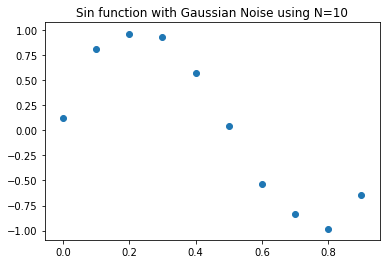

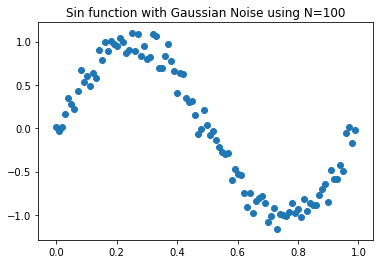


Exercise 2.3: Without using regularized lambda: 




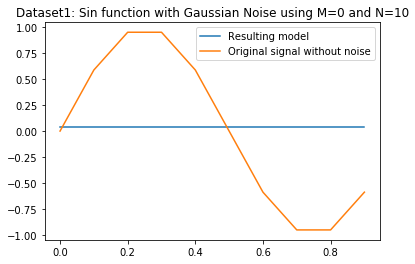

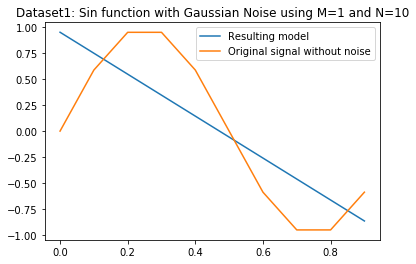

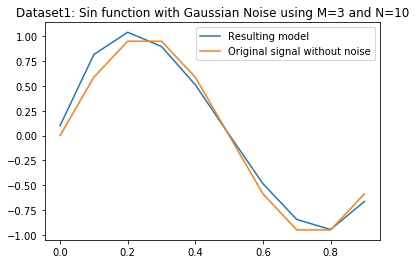

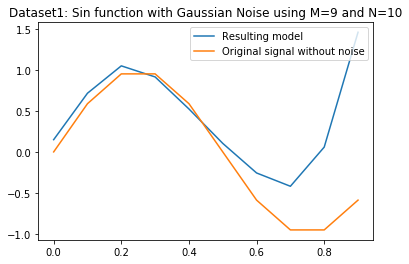

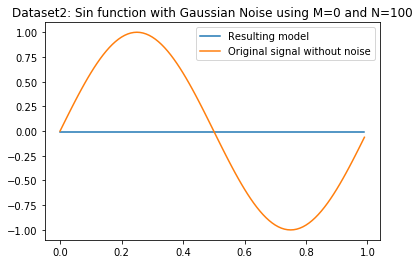

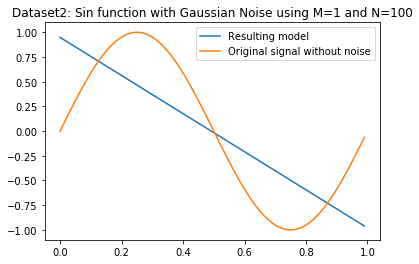

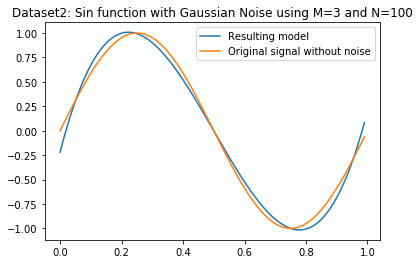

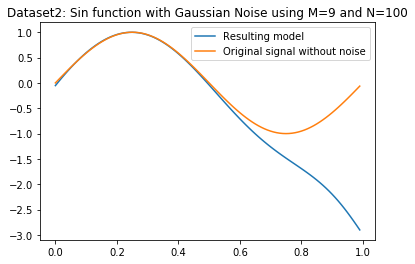

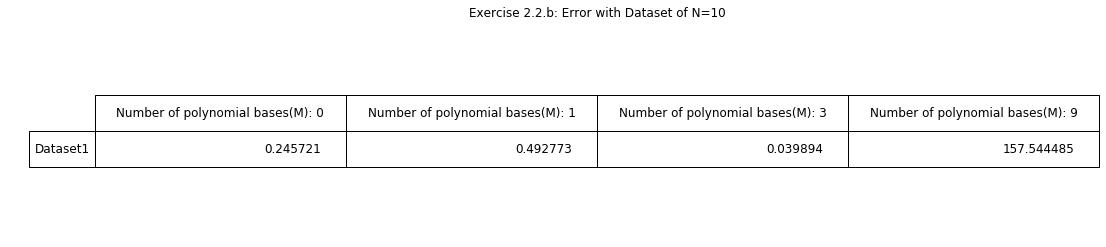

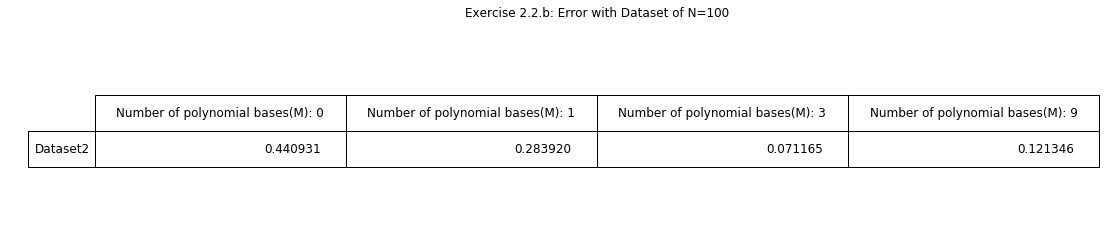


Exercise 2.3: Using regularized lambda: 




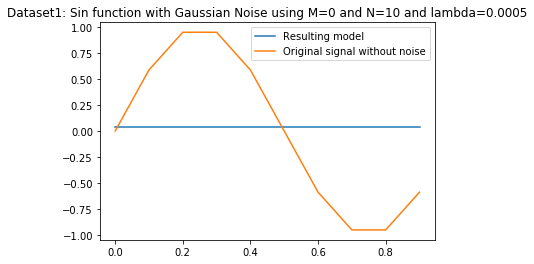

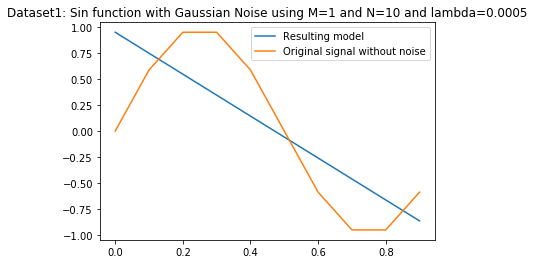

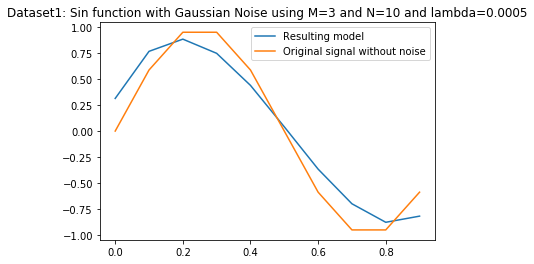

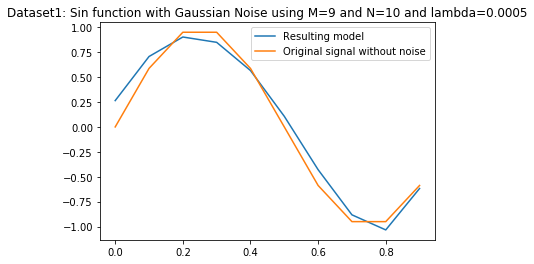

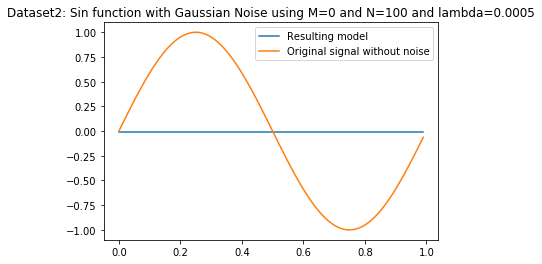

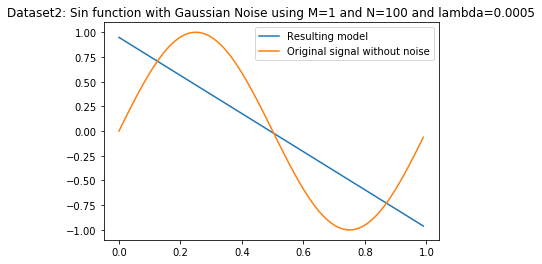

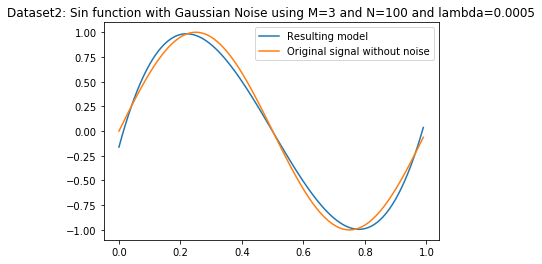

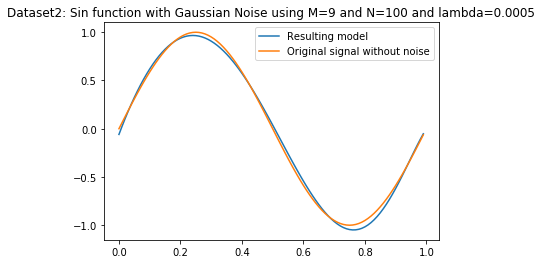

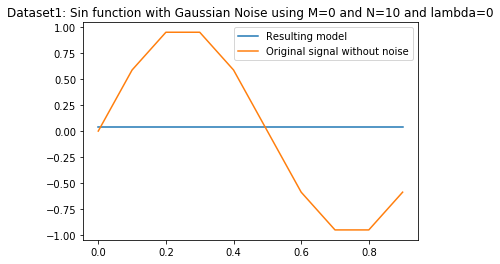

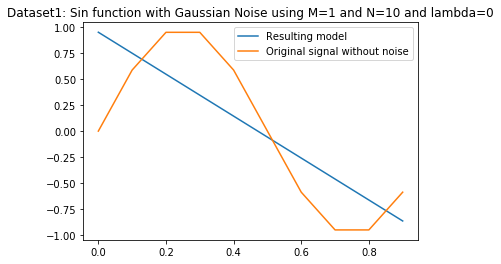

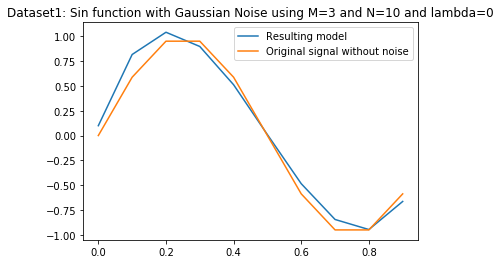

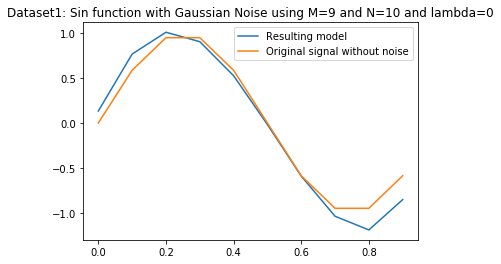

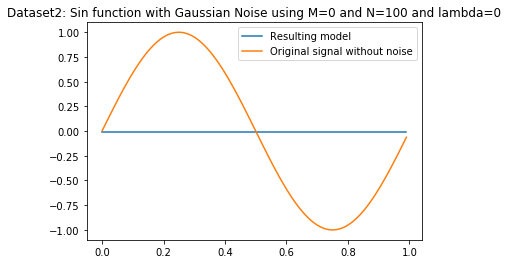

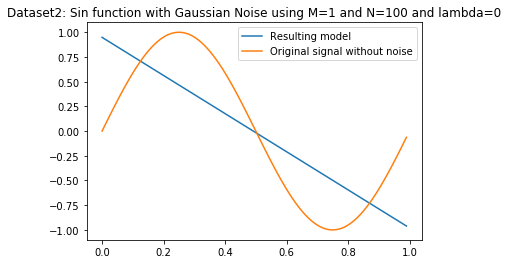

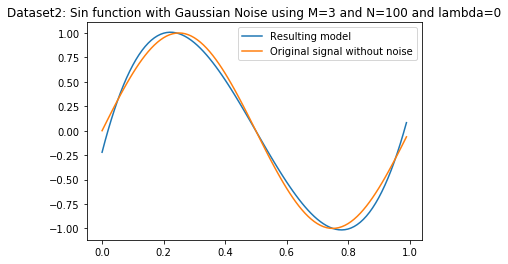

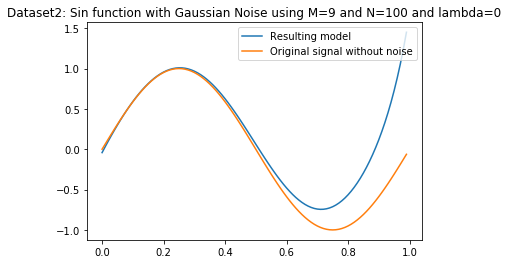

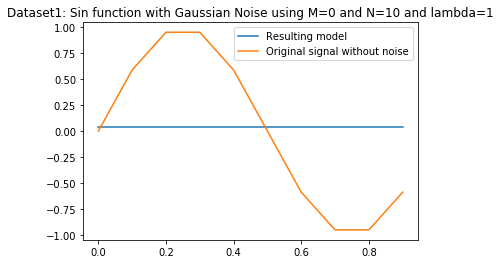

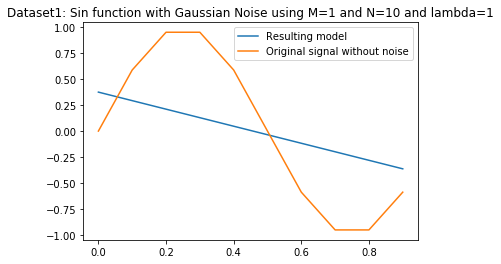

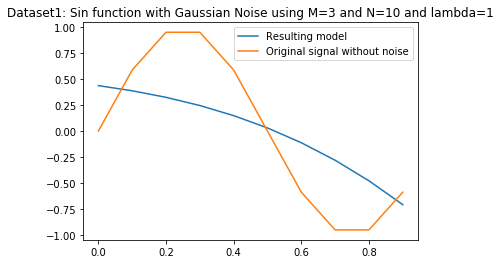

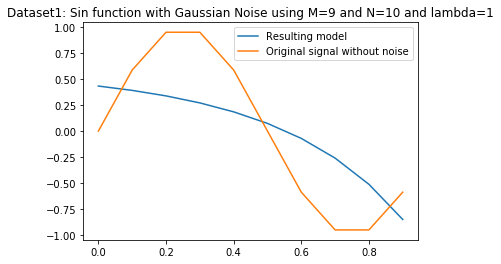

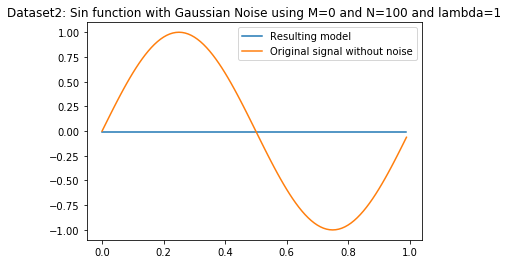

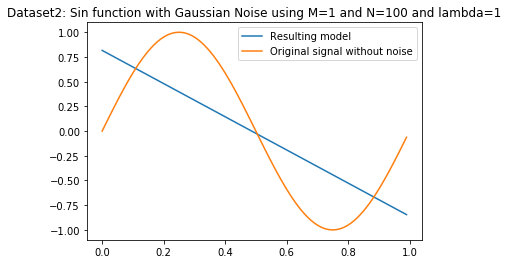

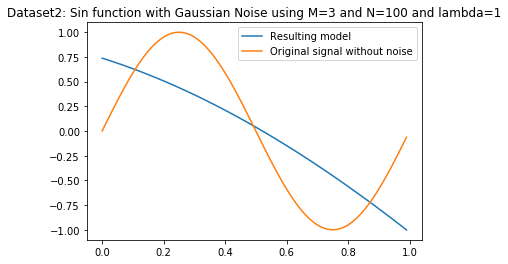

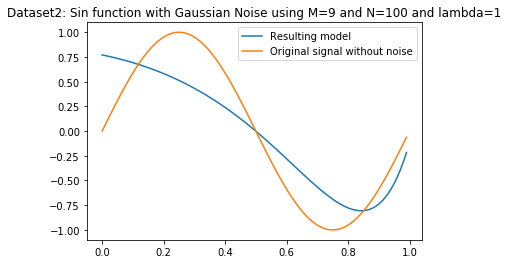

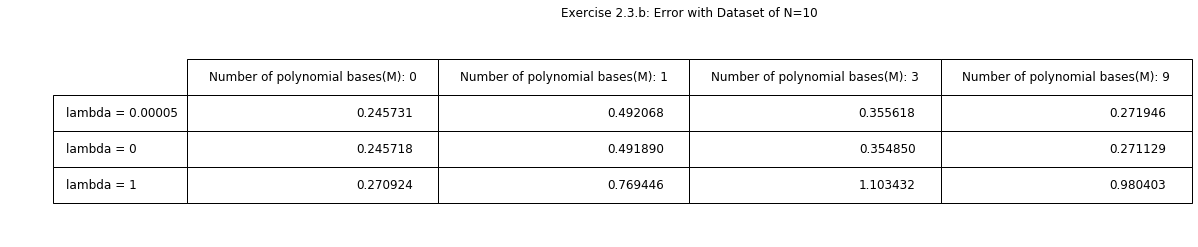

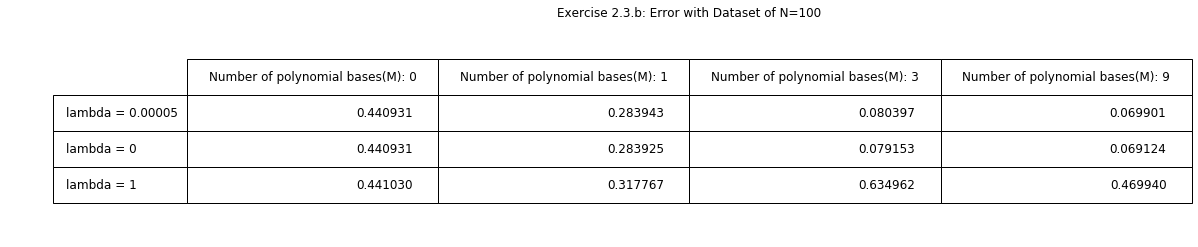

In [158]:
def generate_signal(x, stdNoise=0.1):
    """
    Creates the observation array t, from a sinusoidal wave
    @param x, the x values 
    @param stdNoise, standard d
    eviation of noise, hihger, lower signal to noise ratio
    @return (t, yReal), the observed values and the original signal without noise
    """       
    yReal = np.sin(2* np.pi * x);
    # Create noise
    noise = np.random.normal(0, stdNoise, yReal.shape);
    # Additive gaussian noise                        
    t = yReal + noise;
    return (t, yReal);
  
def generate_x_values(n=10):
    maximum_value = 1
    x = np.arange(0, maximum_value, 1/(n/maximum_value));   
    return x
  
def plot_scattered_signal(x, y, title):
    # Scatter of the noisy signal
    plt.scatter(x, y);
    plt.title(title)
    plt.show()

def plot_continuous_signal(x, y1, y_real, title):
    # Scatter of the noisy signal
    plt.plot(x, y1, x, y_real);
    plt.title(title)
    plt.legend(('Resulting model', 'Original signal without noise'),
           loc='upper right')
    plt.show()
    
def get_optimum_w_using_lambda(x, t, M, lambdaF=0.0005):
    # Create base matrix X
    X = np.tile(x,(M,1)).T
    
    # Power matrix elements
    N = len(x)
    for i in range(0, N):
      for j in range(0, M):
        X[i][j] = np.power(X[i][j], j+1)
        
    # Append bias column to X
    biasT = np.ones(len(x)).reshape((len(x),1))
    X = np.concatenate((biasT, X), axis=1)
    
    # Translate as Torch Tensor
    X = torch.from_numpy(X).type(torch.FloatTensor)
    T = torch.from_numpy(t).type(torch.FloatTensor)
    T = T.reshape(-1, T.shape[0])
    
    # print("\nTranspose X mm X and lambda", X.transpose(0, 1).mm(X) + lambdaF*I)
    inversePart = X.transpose(0, 1).mm(X)
    I = torch.eye(list(inversePart.size())[0], list(inversePart.size())[1])
    wOpt = (inversePart + lambdaF*I).inverse().mm(X.transpose(0, 1)).mm(T.transpose(0, 1))
    
    return wOpt
    
    
def get_optimum_w_using_summation(x, t, M):
    def power_matrixA_data(x, degree):
        x_power = np.power(x, degree)
        return np.sum(x_power)
  
    def power_matrixB_data(x, t, degree):
        x_power = np.power(x, degree)
        multiply_factor = np.multiply(x_power, t)
        return np.sum(multiply_factor)
  
    # Create base matrix A
    A = np.ones((M+1, M+1))
    for i in range(0, M+1):
      for j in range(0, M+1):
        A[i][j] = power_matrixA_data(x, i + j)
    
    # Create matrix B
    B = torch.ones(M+1, 1)
    B = B.numpy()
    for i in range(0, M+1):
      B[i] = power_matrixB_data(x, t, i)
      
    # Translate as Torch Tensor
    A = torch.from_numpy(A).type(torch.FloatTensor)
    B = torch.from_numpy(B)
    
    return A.inverse().mm(B)
 
def getY(x, wOpt, M):
    """
    According to the weights w, evaluates the polynomial model
    @param x value to evaluate... i.e. y(xScalar)
    @param w, array of weights for the polynomial model
    @return y
    """
    N = len(x)
    y = np.zeros(N)
    w = wOpt.transpose(0, 1)
    w = w.numpy()[0]

    for i in range(0, N):
      sum_value = 0
      for j in range(0, M+1):
        sum_value += w[j]*(x[i]**j)
      y[i] = sum_value
    
    return y
  
def calculate_error_exercise_2_2(X_train, X_test, T_train, T_test, dataset):
    wOptPerM = []
    errors = []
    # Train model for DataSet1
    for M in [0, 1, 3, 9]:
      # Get optimum value for specific M
      wOpt = get_optimum_w_using_summation(X_train, T_train, M)
      wOptPerM.append((wOpt, M))
      
    # Get all Estimated Y
    estimatedYPerW = []
    for wOpt in wOptPerM:
      estimatedY = getY(X_test, wOpt[0], wOpt[1])
      estimatedYPerW.append(estimatedY)
      
    # Calculate error
    N = len(X_test) + len(X_train)
    for i, estimatedY in enumerate(estimatedYPerW):
      squared_errors = np.sum(np.square(T_test - estimatedY))/2
      erms = np.sqrt((2*squared_errors)/N)
      errors.append(erms)
      
    return errors

      
def calculate_error_exercise_2_3(X_train, X_test, T_train, T_test, dataset):
    errors = []
    for lambdaF in [0.0005, 0, 1]:
      wOptPerM = []
      # Train model for DataSet1
      for M in [0, 1, 3, 9]:
        # Get optimum value for specific M
        wOpt = get_optimum_w_using_lambda(X_train, T_train, M)
        wOptPerM.append((wOpt, M))

      # Get all Estimated Y
      estimatedYPerW = []
      for wOpt in wOptPerM:
        estimatedY = getY(X_test, wOpt[0], wOpt[1])
        estimatedYPerW.append(estimatedY)

      # Calculate error
      N = len(X_test) + len(X_train)
      for i, estimatedY in enumerate(estimatedYPerW):
        squared_errors = np.sum(np.square(T_test - estimatedY))/2
        regularization = (lambdaF/2)*np.sqrt((np.sum(np.square(wOptPerM[i][0].numpy()))))
        error = squared_errors + regularization
        erms = np.sqrt((2*error)/N)
        errors.append(erms)
    
    return errors
 

def plotPolynomialRegressionErrorTable(error, rowsLabel, title, loc='center'):
    #Table definition
    colLabel = ['Number of polynomial bases(M): %d' % M for M in [0, 1, 3, 9]] 
    
    #plot errors
    fig, ax = plt.subplots()
    ax.title.set_text(title)

    # Hide axes
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.axis("off")
    
      
    # Create text labels for the table
    cell_text = []
    i = 0
    j = i+4

    for row in range(len(rowsLabel)):
        y_offset = np.zeros(len(colLabel))
        y_offset =  y_offset + error[i:j]
        cell_text.append(['%f' % x for x in y_offset])
        i=j
        j=j+4
        if j>= len(error):
          j = len(error)
        
    table = ax.table(cellText=cell_text, rowLabels=rowsLabel, colLabels=colLabel, loc=loc)     
    table.set_fontsize(16)
    table.scale(3, 3)
    plt.show()
    
    

def test_exercise2():
    def test_exercise_2_1():
      # Dataset 1
      x1 = generate_x_values(n=10)
      (t1, y1_real) = generate_signal(x1);
      plot_scattered_signal(x1, t1, "Sin function with Gaussian Noise using N=10")

      # Dataset 2
      print("\n")
      x2 = generate_x_values(n=100)
      (t2, y2_real) = generate_signal(x2);
      plot_scattered_signal(x2, t2, "Sin function with Gaussian Noise using N=100")
      
      return x1, t1, y1_real, x2, t2, y2_real
    
    def test_exercise_2_2(x1, t1, y1_real, x2, t2, y2_real):
      # For Dataset x1 and t1
      for M in [0, 1, 3, 9]:
        # Get optimum value
        wOpt = get_optimum_w_using_summation(x1, t1, M)
        # Plot Fit Y Estimated
        y1 = getY(x1, wOpt, M)
        print("\n")
        plot_continuous_signal(x1, y1, y1_real, "Dataset1: Sin function with Gaussian Noise using M=" + str(M)+ " and N=10")
      
      # For Dataset x2 and t2
      for M in [0, 1, 3, 9]:
        # Get optimum value
        wOpt = get_optimum_w_using_summation(x2, t2, M)
        # Plot Fit Y Estimated
        y2 = getY(x2, wOpt, M)
        print("\n")
        plot_continuous_signal(x2, y2, y2_real, "Dataset2: Sin function with Gaussian Noise using M=" + str(M) + " and N=100")
        
    def test_exercise_2_3(x1, t1, y1_real, x2, t2, y2_real):
      for lambdaF in [0.0005, 0, 1]:
        # For Dataset x1 and t1
        for M in [0, 1, 3, 9]:
          # Get optimum value
          wOpt = get_optimum_w_using_lambda(x1, t1, M, lambdaF)
          # Plot Fit Y Estimated
          y1 = getY(x1, wOpt, M)
          print("\n")
          plot_continuous_signal(x1, y1, y1_real, "Dataset1: Sin function with Gaussian Noise using M=" + str(M)+ " and N=10 and lambda=" + str(lambdaF))

        # For Dataset x2 and t2
        for M in [0, 1, 3, 9]:
          # Get optimum value
          wOpt = get_optimum_w_using_lambda(x2, t2, M, lambdaF)
          # Plot Fit Y Estimated
          y2 = getY(x2, wOpt, M)
          print("\n")
          plot_continuous_signal(x2, y2, y2_real, "Dataset2: Sin function with Gaussian Noise using M=" + str(M) + " and N=100 and lambda=" + str(lambdaF))
    
    # Test exercise 2.1
    x1, t1, y1_real, x2, t2, y2_real = test_exercise_2_1()
    
    # Define the set of training samples as 70% (randomly selected) and test samples as 30%.
    X1_train, X1_test, T1_train, T1_test = tts(x1, t1, test_size = 0.3)
    X2_train, X2_test, T2_train, T2_test = tts(x2, t2, test_size = 0.3)
    
    # Test exercise 2.2
    print("\nExercise 2.3: Without using regularized lambda: ")
    test_exercise_2_2(x1, t1, y1_real, x2, t2, y2_real)
    error1 = calculate_error_exercise_2_2(X1_train, X1_test, T1_train, T1_test, "Dataset1")
    error2 = calculate_error_exercise_2_2(X2_train, X2_test, T2_train, T2_test, "Dataset2")
    
    # Plot error1
    plotPolynomialRegressionErrorTable(error1, ['Dataset1'], 'Exercise 2.2.b: Error with Dataset of N=10')
    
    # Plot error2
    plotPolynomialRegressionErrorTable(error2, ['Dataset2'], 'Exercise 2.2.b: Error with Dataset of N=100')
    
    # Test exercise 2.3
    print("\nExercise 2.3: Using regularized lambda: ")
    test_exercise_2_3(x1, t1, y1_real, x2, t2, y2_real)
    error1 = calculate_error_exercise_2_3(X1_train, X1_test, T1_train, T1_test, "Dataset1")
    error2 = calculate_error_exercise_2_3(X2_train, X2_test, T2_train, T2_test, "Dataset2")
    
    # Plot error1
    plotPolynomialRegressionErrorTable(error1, ['lambda = 0.00005', 'lambda = 0', 'lambda = 1'], 'Exercise 2.3.b: Error with Dataset of N=10')
    
    # Plot error2
    plotPolynomialRegressionErrorTable(error2, ['lambda = 0.00005', 'lambda = 0', 'lambda = 1'], 'Exercise 2.3.b: Error with Dataset of N=100')

    
test_exercise2()